In [2]:
import pandas as pd
import torch
import re
import nltk
import nltk.data
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime
import warnings


pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# Ensure necessary NLTK resources are available
def download_nltk_resources():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    try:
        nltk.data.find('sentiment/vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon')

download_nltk_resources()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\count\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Load pre-trained BERT sentiment model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="model_cache")
model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir="model_cache")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()




# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

In [5]:
# Function to apply sentiment prediction in batches
def bert_batch_predict(sentences):
    if not all(isinstance(s, str) for s in sentences):
        raise ValueError("All inputs must be strings")

    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
    return probabilities.tolist(), ["Positive" if p > 0.6 else "Negative" if p < 0.4 else "Neutral" for p in probabilities]

In [6]:
# Function to compute VADER sentiment
def vader_sentiment(sentence):
    sentiment_score = sia.polarity_scores(sentence)['compound']
    if sentiment_score >= 0.05:
        return sentiment_score, "Positive"
    elif sentiment_score <= -0.05:
        return sentiment_score, "Negative"
    else:
        return sentiment_score, "Neutral"

In [7]:
print(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S"))

02.Mar 2025 13:49:06


In [8]:
filelist = ['./datasets/__sprint1_filtered_gameplay_review_set',
            './datasets/__sprint1_filtered_functionality_review_set',
            './datasets/__sprint1_filtered_usability_review_set']

set_names = ['gameplay', 'functionality','usability']

for index in range(len(filelist)):
    df = pd.read_csv(filelist[index] + '.csv', encoding='utf-8')
    df = df.dropna(subset=['tokenized_sentence'])
    df['tokenized_sentence'] = df['tokenized_sentence'].astype(str)
    df = df[df['tokenized_sentence'].str.strip() != ""]
    
    # Convert the column to a NumPy array for efficient slicing
    df_sentences_list = df['tokenized_sentence'].values  # Use .values instead of .tolist() for better performance
    
    # Batch processing
    batch_size = 32
    num_batches = int(np.ceil(len(df_sentences_list) / batch_size))  # Compute the number of batches
    
    # Initialize arrays for efficiency
    bert_scores = np.zeros(len(df_sentences_list))
    bert_labels = np.empty(len(df_sentences_list), dtype=object)
    vader_scores = np.zeros(len(df_sentences_list))
    vader_labels = np.empty(len(df_sentences_list), dtype=object)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(df_sentences_list))
        batch_sentences = df_sentences_list[start_idx:end_idx].tolist()  # Convert NumPy array to list
    
        # DistilBERT Sentiment Prediction
        scores, labels = bert_batch_predict(batch_sentences)  # Pass list to function
        bert_scores[start_idx:end_idx] = scores
        bert_labels[start_idx:end_idx] = labels
    
        # VADER Sentiment Prediction
        vader_results = np.array([vader_sentiment(sentence) for sentence in batch_sentences])
        vader_scores[start_idx:end_idx] = vader_results[:, 0]
        vader_labels[start_idx:end_idx] = vader_results[:, 1]
    
    # Assign predictions back to the DataFrame
    df["bert_score"] = bert_scores
    df["bert_label"] = bert_labels
    df["vader_score"] = vader_scores
    df["vader_label"] = vader_labels
    df.to_csv(filelist[index] + '_with_sentiment_scores.csv', index=False)

In [9]:
#Started execution at 21:50 

In [10]:
print(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S"))

02.Mar 2025 14:22:10


In [11]:
df.tail(20)

,Unnamed: 0,recommendationid,clean_sentence,tokenized_sentence,voted_up,informative,heuristic,bert_score,bert_label,vader_score,vader_label
64918,523443,68025850,cant get money back return policy play period ...,you cant get your money back from steam becaus...,0,1.0,"[('G', 'U')]",0.001171,Negative,0.4939,Positive
64919,523453,24880894,controlls flight fucking joke,the controlls in flight is a fucking joke,1,1.0,"[('U',)]",0.001153,Negative,0.3597,Positive
64920,523479,24991843,lack storage space sucks understandable trying...,lack of storage space sucks but its understand...,0,1.0,"[('U',)]",0.008199,Negative,-0.3400,Negative
64921,523500,43837030,intuitive tutorial beginning bit rough,there is no intuitive tutorial so the beginnin...,1,1.0,"[('U',)]",0.000325,Negative,-0.2960,Negative
64922,523501,24934236,eventually ill need supplies soon start mining...,eventually ill need supplies and as soon as i ...,1,1.0,"[('U',)]",0.002627,Negative,-0.4215,Negative
64923,523519,24940056,biggest problem inventory management,the biggest problem i have it with is inventor...,0,1.0,"[('G', 'U')]",0.000693,Negative,-0.4019,Negative
64924,523542,54819128,tho developers fixed linux support pretty nice...,tho the developers fixed the linux vr support ...,1,1.0,"[('U',)]",0.773704,Positive,0.7426,Positive
64925,523545,30501987,use stuff though thats neat,you can use their stuff though so thats neat,1,1.0,"[('U',)]",0.983361,Positive,0.5070,Positive
64926,523547,24902853,lacks depth far,lacks depth so far,1,1.0,"[('U',)]",0.000298,Negative,0.0000,Neutral
64927,523563,24867214,got bored quickly launch liking,i got bored quickly after launch but now im li...,1,1.0,"[('G', 'U')]",0.998245,Positive,0.4588,Positive


In [12]:
g_set = pd.read_csv('datasets/__sprint1_filtered_gameplay_review_set_with_sentiment_scores.csv', encoding='utf-8')
u_set = pd.read_csv('datasets/__sprint1_filtered_usability_review_set_with_sentiment_scores.csv', encoding='utf-8')
f_set = pd.read_csv('datasets/__sprint1_filtered_functionality_review_set_with_sentiment_scores.csv', encoding='utf-8')

In [13]:
g_set.tail()

,Unnamed: 0,recommendationid,clean_sentence,tokenized_sentence,voted_up,informative,heuristic,bert_score,bert_label,vader_score,vader_label
118726,523608,46006553,exploring,exploring,0,1.0,"[('G',)]",0.999738,Positive,0.0000,Neutral
118727,523610,24966390,guys making joe danger life first new game big...,these guys have been making joe danger most of...,1,1.0,"[('G',)]",0.997516,Positive,-0.5267,Negative
118728,523617,24863026,fanatastic exploration game,its a fanatastic exploration game,1,1.0,"[('G',)]",0.999661,Positive,0.2263,Positive
118729,523629,66834086,games awesome youre exploration discovery amaz...,this games awesome if youre into exploration d...,1,1.0,"[('G',)]",0.998691,Positive,0.8910,Positive
118730,523643,25174939,homogenous resource availability,homogenous resource availability 5,0,1.0,"[('G',)]",0.926759,Positive,0.0000,Neutral


In [14]:
g_avg_bert = g_set['bert_score'].mean()
g_avg_vader = g_set['vader_score'].mean()
f_avg_bert = f_set['bert_score'].mean()
f_avg_vader = f_set['vader_score'].mean()
u_avg_bert = u_set['bert_score'].mean()
u_avg_vader = u_set['vader_score'].mean()

In [15]:
print(g_set['bert_score'].max())

0.9998948574066162


In [16]:
print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)
g_avg_bert = g_avg_bert * 2 -1
f_avg_bert = f_avg_bert * 2 -1
u_avg_bert = u_avg_bert * 2 -1
print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)


0.46668513802892964
0.28753227327489317
0.3575584030640064
-0.06662972394214073
-0.42493545345021366
-0.28488319387198724


In [17]:
print(g_avg_vader)
print(f_avg_vader)
print(u_avg_vader)

0.16328032443085627
0.0478551458950982
0.06781070405617666


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


#Add new "radar" projection to matplot lib
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


radar_factory(3, frame='polygon')

array([0.       , 2.0943951, 4.1887902])

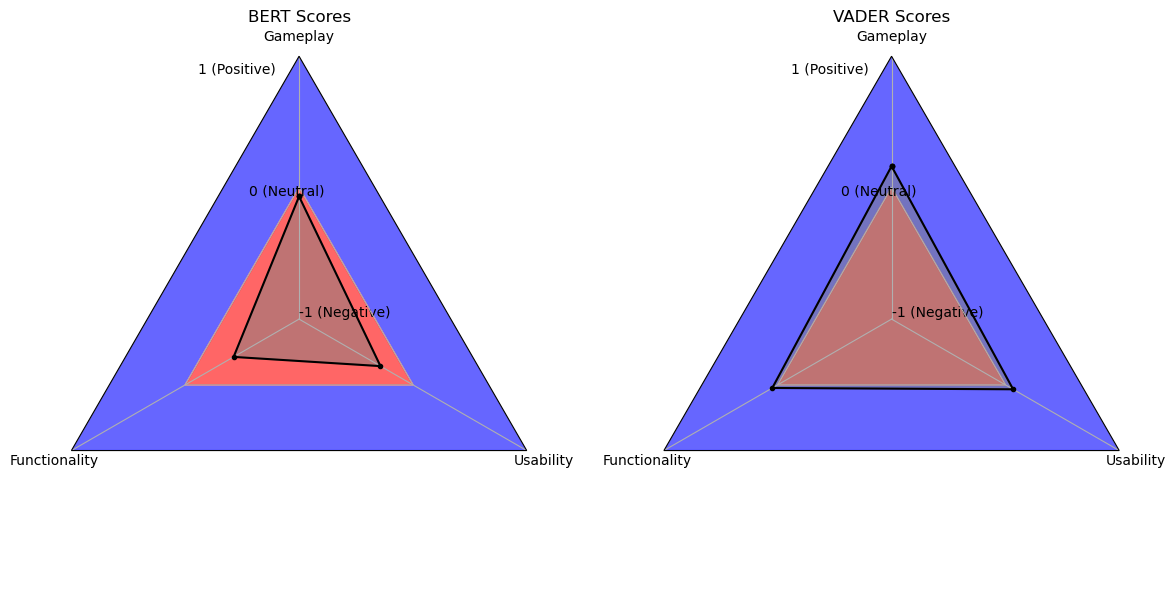

In [21]:

# Define categories (3 metrics for triangular radar chart)
categories = ['Gameplay', 'Functionality', 'Usability']


# Sample values ranging from -1 to 1
values0 = [0,0,0]  # Dataset 1
values0 += [values0[0]]
values9 = [1,1,1]  # Dataset 1
values9 += [values9[0]]

values1 = [g_avg_bert, f_avg_bert, u_avg_bert]  # Dataset 1
values2 = [g_avg_vader, f_avg_vader, u_avg_vader]  # Dataset 2

# Ensure the data closes the radar chart
values1 += [values1[0]]
values2 += [values2[0]]

# Generate angles for the radar chart (3 axes for triangle shape)
angles = np.linspace(0, 2 * np.pi, len(categories) + 1, endpoint=True)

# Create subplots for two radar charts
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='radar'), figsize=(12,7))
#fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='radar'), figsize=(12,7))

# Function to adjust radial limits for values between -1 and 1
def adjust_polar_axis(ax):
    ax.set_ylim(-1, 1)  # Set limits to allow negative values
    ax.set_yticks([-1, 0, 1])  # Define y-axis ticks
    ax.set_yticklabels(['-1 (Negative)',  '0 (Neutral)', '1 (Positive)'])  # Labels for y-axis
    ax.set_xticks(angles[:-1])  # Set category labels at correct angles
    ax.set_xticklabels(categories)

# Plot first triangular radar chart
axs[0].fill(angles, values9, color='b', alpha=0.6)
axs[0].fill(angles, values0, color='white', alpha=1)
axs[0].fill(angles, values0, color='r', alpha=0.6)

axs[0].plot(angles, values1, marker='.', linestyle='solid', color='black', label="BERT Scores")
axs[0].fill(angles, values1, color='grey', alpha=.5)
adjust_polar_axis(axs[0])
axs[0].set_title("BERT Scores")

# Plot second triangular radar chart
axs[1].fill(angles, values9, color='b', alpha=0.6)
axs[1].fill(angles, values0, color='white', alpha=1)
axs[1].fill(angles, values0, color='r', alpha=0.6)

axs[1].plot(angles, values2, marker='.', linestyle='solid', color='black', label="VADER Scores")
axs[1].fill(angles, values2, color='grey', alpha=.5)
adjust_polar_axis(axs[1])
axs[1].set_title("VADER Scores")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('bert_vader_comparison_plots.png')
plt.show()

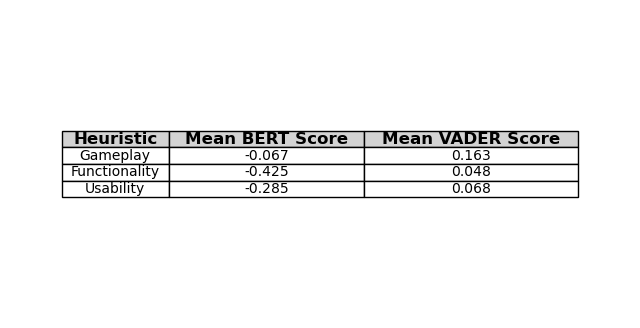

In [33]:

# Define table data
data = [
    #["Heuristic", "Mean BERT Score", "Mean VADER Score"],
    ["Gameplay", f"{g_avg_bert:.3f}", f"{g_avg_vader:.3f}"],
    ["Functionality", f"{f_avg_bert:.3f}", f"{f_avg_vader:.3f}"],
    ["Usability",f"{u_avg_bert:.3f}", f"{u_avg_vader:.3f}"]
]

# Define column labels
columns = ["Heuristic", "Mean BERT Score", "Mean VADER Score"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table
table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center')

# Styling the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])  # Adjust column widths

# Style the header row (make it bold and set background color to grey)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgrey')

# Display table
plt.savefig('mean_sentiment_score_results_table.png')
plt.show()


In [25]:
selected_df = [ g_set, f_set, u_set ]

g_set['bert_score_normalised'] = g_set['bert_score'] * 2
g_set['bert_score_normalised'] = g_set['bert_score_normalised'] - 1

f_set['bert_score_normalised'] = f_set['bert_score'] * 2
f_set['bert_score_normalised'] = f_set['bert_score_normalised'] - 1

u_set['bert_score_normalised'] = u_set['bert_score'] * 2
u_set['bert_score_normalised'] = u_set['bert_score_normalised'] - 1


print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)
print(g_set['bert_score_normalised'].mean())
print(f_set['bert_score_normalised'].mean())
print(u_set['bert_score_normalised'].mean())


-0.06662972394214073
-0.42493545345021366
-0.28488319387198724
-0.06662972394214074
-0.42493545345021366
-0.28488319387198724


In [ ]:
u_set.tail(10)

<Axes: >

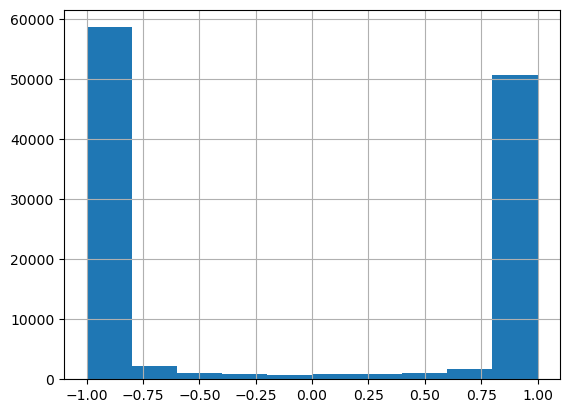

In [29]:
g_set['bert_score_normalised'].hist()

In [37]:
print(len(g_set['bert_score_normalised']))
print(len(f_set['bert_score_normalised']))
print(len(u_set['bert_score_normalised']))

118731
44861
64938


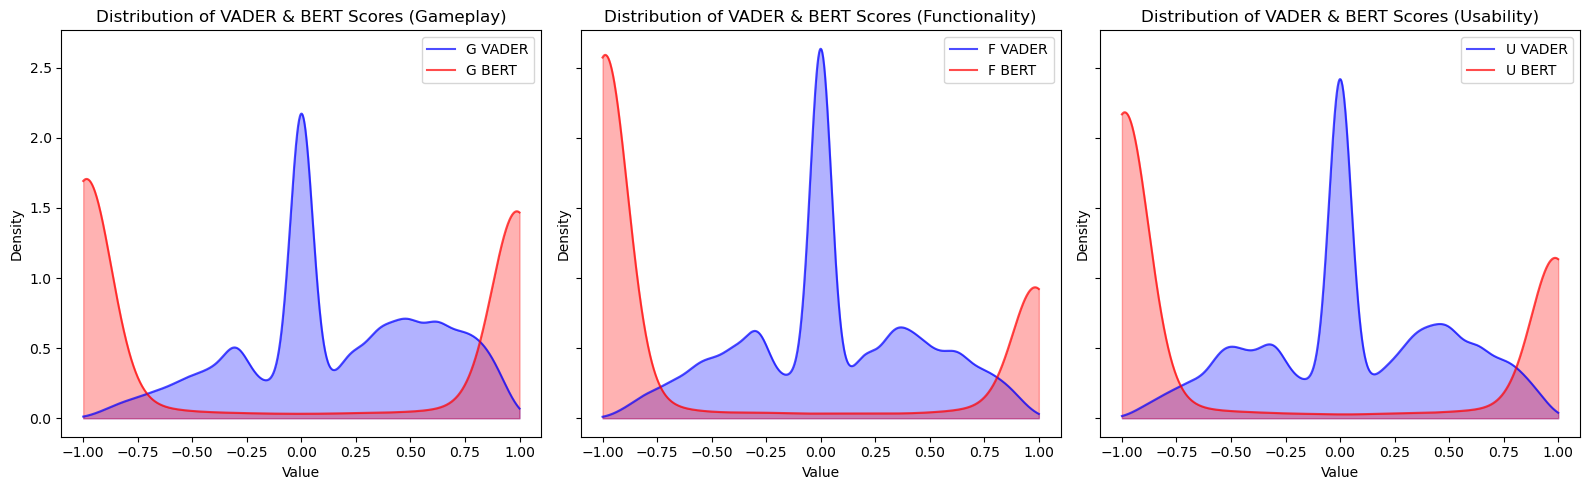

In [73]:
from scipy.stats import gaussian_kde

n= len(f_set['bert_score_normalised'])

g_sample = g_set.sample(n)
f_sample = f_set.sample(n)
u_sample = u_set.sample(n)



# Generate sample data ensuring numerical types
np.random.seed(1)
df = pd.DataFrame({
    'G VADER': g_sample['vader_score'].astype(float).to_numpy(),
    'G BERT': g_sample['bert_score_normalised'].astype(float).to_numpy(),
    'F VADER': f_sample['vader_score'].astype(float).to_numpy(),
    'F BERT': f_sample['bert_score_normalised'].astype(float).to_numpy(),
    'U VADER': u_sample['vader_score'].astype(float).to_numpy(),
    'U BERT': u_sample['bert_score_normalised'].astype(float).to_numpy()
})

# Define feature pairs for each subplot
feature_pairs = [('G VADER', 'G BERT'), ('F VADER', 'F BERT'), ('U VADER', 'U BERT')]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)


index = 0
chart_titles = ['Distribution of VADER & BERT Scores (Gameplay)',
               'Distribution of VADER & BERT Scores (Functionality)',
               'Distribution of VADER & BERT Scores (Usability)']

# Loop through feature pairs and create KDE plots
for ax, (feature_x, feature_y) in zip(axs, feature_pairs):
    # Compute KDE using scipy for both features
    x_vals = np.linspace(-1, 1, 1000)
    
    kde_x = gaussian_kde(df[feature_x])
    kde_y = gaussian_kde(df[feature_y])
    
    y_x = kde_x(x_vals)
    y_y = kde_y(x_vals)

    # Plot both KDE curves
    ax.plot(x_vals, y_x, label=feature_x, color="blue", alpha=0.7)
    ax.fill_between(x_vals, y_x, alpha=0.3, color="blue")

    ax.plot(x_vals, y_y, label=feature_y, color="red", alpha=0.7)
    ax.fill_between(x_vals, y_y, alpha=0.3, color="red")

    # Labels and title for each subplot
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{chart_titles[index]}")
    ax.legend()
    index +=1

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("bert_and_vader_score_distribution_charts.png")
plt.show()